In [1]:
import pandas as pd

eda_df = pd.read_csv("short_term_spend_model_data.csv")

eda_df.head()


,customer_id,transaction_date,daily_spend,total_qty,avg_price,transactions,avg_discount,next_30d_spend,region,city,gender,age,store_type
0,C00001,2025-09-18,593.16,2,296.58,2,0.0,5351.521955,South,Southport,M,41,Outlet
1,C00001,2025-09-19,49.72,4,12.43,1,0.0,5318.911955,South,Southport,M,41,Outlet
2,C00001,2025-09-21,97.61,1,97.61,1,0.0,5465.471955,South,Southport,M,41,Outlet
3,C00001,2025-09-23,360.00,2,180.00,1,0.0,5951.431955,South,Southport,M,41,Outlet
4,C00001,2025-09-24,500.00,2,250.00,1,0.0,6443.543630,South,Southport,M,41,Outlet


In [40]:
eda_df.columns


Index(['customer_id', 'transaction_date', 'daily_spend', 'total_qty',
       'avg_price', 'transactions', 'avg_discount', 'next_30d_spend', 'region',
       'city', 'gender', 'age', 'store_type'],
      dtype='object')

In [2]:
df = eda_df.copy()

X = df.drop(columns=["next_30d_spend", "transaction_date"])
y = df["next_30d_spend"]


In [3]:
X = pd.get_dummies(X, columns=["region", "city", "gender", "store_type"], drop_first=True)


In [4]:
X.shape

(19211, 29)

In [5]:
X.head()

,customer_id,daily_spend,total_qty,avg_price,transactions,avg_discount,age,region_East,region_North,region_South,...,city_Oakridge,city_Rivermouth,city_Southport,city_Sunvale,city_Winterton,gender_M,gender_O,store_type_OnlineHub,store_type_Outlet,store_type_Street
0,C00001,593.16,2,296.58,2,0.0,41,False,False,True,...,False,False,True,False,False,True,False,False,True,False
1,C00001,49.72,4,12.43,1,0.0,41,False,False,True,...,False,False,True,False,False,True,False,False,True,False
2,C00001,97.61,1,97.61,1,0.0,41,False,False,True,...,False,False,True,False,False,True,False,False,True,False
3,C00001,360.00,2,180.00,1,0.0,41,False,False,True,...,False,False,True,False,False,True,False,False,True,False
4,C00001,500.00,2,250.00,1,0.0,41,False,False,True,...,False,False,True,False,False,True,False,False,True,False


In [7]:
df["transaction_date"] = pd.to_datetime(df["transaction_date"])


In [10]:
df_sorted = df.sort_values("transaction_date")

split_date = df_sorted["transaction_date"].quantile(0.8)

train = df_sorted[df_sorted["transaction_date"] <= split_date]
test = df_sorted[df_sorted["transaction_date"] > split_date]

X_train = train.drop(columns=["next_30d_spend", "transaction_date", "customer_id"])
y_train = train["next_30d_spend"]

X_test  = test.drop(columns=["next_30d_spend", "transaction_date", "customer_id"])
y_test = test["next_30d_spend"]

# Encode categoricals again
X_train = pd.get_dummies(X_train, columns=["region", "city", "gender", "store_type"], drop_first=True)
X_test = pd.get_dummies(X_test, columns=["region", "city", "gender", "store_type"], drop_first=True)

# Align columns
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Results")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2:", r2_score(y_test, y_pred_rf))


Random Forest Results
MAE: 2815.889551009124
RMSE: 3942.455801083973
R2: 0.4894388231645289


In [12]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost Results")
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("R2:", r2_score(y_test, y_pred_xgb))


XGBoost Results
MAE: 2045.9867287995726
RMSE: 2842.610392626382
R2: 0.7345707373749051


In [13]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("Linear Regression")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R2:", r2_score(y_test, y_pred_lr))


Linear Regression
MAE: 3613.7798837034948
RMSE: 4842.4537110911315
R2: 0.2297262859791357


In [14]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

print("\nRidge Regression")
print("MAE:", mean_absolute_error(y_test, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("R2:", r2_score(y_test, y_pred_ridge))



Ridge Regression
MAE: 3613.737680050829
RMSE: 4842.422422279857
R2: 0.22973623997041503


In [15]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X_test)

print("\nGradient Boosting")
print("MAE:", mean_absolute_error(y_test, y_pred_gbr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gbr)))
print("R2:", r2_score(y_test, y_pred_gbr))



Gradient Boosting
MAE: 2649.8803796783864
RMSE: 3607.294012623622
R2: 0.5725579899118798


In [16]:
results = pd.DataFrame({
    "Model": ["Linear", "Ridge", "RandomForest", "GradientBoosting", "XGBoost"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_ridge),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_gbr),
        mean_absolute_error(y_test, y_pred_xgb)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_gbr)),
        np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    ],
    "R2": [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_ridge),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_gbr),
        r2_score(y_test, y_pred_xgb)
    ]
})

results


,Model,MAE,RMSE,R2
0,Linear,3613.779884,4842.453711,0.229726
1,Ridge,3613.737680,4842.422422,0.229736
2,RandomForest,2815.889551,3942.455801,0.489439
3,GradientBoosting,2649.880380,3607.294013,0.572558
4,XGBoost,2045.986729,2842.610393,0.734571


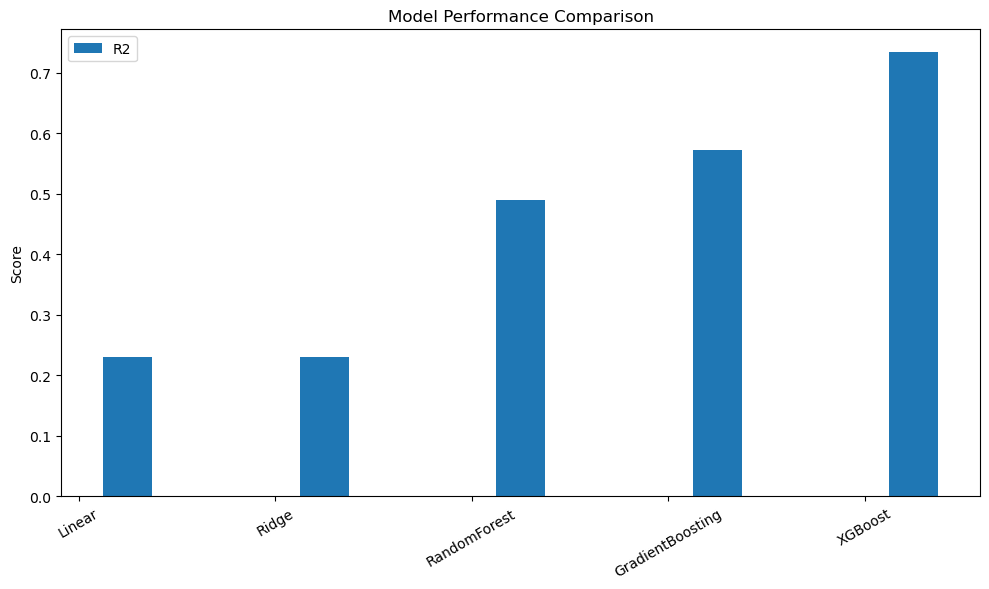

In [18]:
import matplotlib.pyplot as plt
import numpy as np

models = results["Model"]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(10,6))

# plt.bar(x - width, results["MAE"], width, label="MAE")
# plt.bar(x, results["RMSE"], width, label="RMSE")
plt.bar(x + width, results["R2"], width, label="R2")

plt.xticks(x, models, rotation=30)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
features = ["daily_spend", "total_qty", "avg_price", "transactions", "avg_discount"]
target = "next_30d_spend"

df = df.sort_values(["customer_id", "transaction_date"])


In [29]:
train_list = []
test_list = []

for cust in df["customer_id"].unique():
    cust_df = df[df["customer_id"] == cust].sort_values("transaction_date")

    if len(cust_df) < 40:   # Need at least 30+10 days
        continue

    split = int(len(cust_df) * 0.8)
    train_list.append(cust_df.iloc[:split])
    test_list.append(cust_df.iloc[split:])

train = pd.concat(train_list)
test  = pd.concat(test_list)


In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train[features] = scaler.fit_transform(train[features])
test[features]  = scaler.transform(test[features])


In [35]:
def make_sequences_all(df, window=30):
    X, y = [], []

    for cust in df["customer_id"].unique():
        cust_df = df[df["customer_id"] == cust].sort_values("transaction_date")

        if len(cust_df) <= window:
            continue

        values = cust_df[features].values
        labels = cust_df[target].values

        for i in range(len(cust_df) - window):
            X.append(values[i:i+window])
            y.append(labels[i+window])

    return np.array(X), np.array(y)

X_all, y_all = make_sequences_all(df)

print(X_all.shape)


(11733, 30, 5)


In [36]:
split = int(len(X_all) * 0.8)

X_train_seq = X_all[:split]
y_train_seq = y_all[:split]

X_test_seq  = X_all[split:]
y_test_seq  = y_all[split:]

print(X_train_seq.shape, X_test_seq.shape)


(9386, 30, 5) (2347, 30, 5)


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, 5)),
    Dropout(0.2),

    LSTM(32),
    Dense(1)
])

model.compile(
    loss="mse",
    optimizer=Adam(0.001)
)

model.summary()


C:\Users\Dell\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=20,
    batch_size=64
)


Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 124734904.0000 - val_loss: 138054096.0000
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 124395784.0000 - val_loss: 137947568.0000
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 123848320.0000 - val_loss: 137846656.0000
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 127356624.0000 - val_loss: 137748144.0000
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 122206520.0000 - val_loss: 137650080.0000
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 124347312.0000 - val_loss: 137552768.0000
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 124999512.0000 - val_loss: 137456224.0000
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 124563496.0000 - val_loss: 137359792.0000
Epoch 9/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 124410352.0000 - val_loss: 137263840.0000
Epoch 10/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 125300968.

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pred = model.predict(X_test_seq).ravel()

mae = mean_absolute_error(y_test_seq, pred)
rmse = np.sqrt(mean_squared_error(y_test_seq, pred))
r2 = r2_score(y_test_seq, pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)


74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
MAE: 9810.456174769666
RMSE: 11671.182477935012
R2: -2.407844853600896


In [42]:
import joblib

joblib.dump(xgb, "xgboost_spend_model.pkl")


['xgboost_spend_model.pkl']

In [43]:
joblib.dump(scaler, "feature_scaler.pkl")

['feature_scaler.pkl']

In [44]:
import json

feature_columns = X_train.columns.tolist()

with open("feature_columns.json", "w") as f:
    json.dump(feature_columns, f)

print("feature_columns.json saved with", len(feature_columns), "columns")


feature_columns.json saved with 28 columns


In [45]:
X_train.columns

Index(['daily_spend', 'total_qty', 'avg_price', 'transactions', 'avg_discount',
       'age', 'region_East', 'region_North', 'region_South', 'region_West',
       'city_Centrum', 'city_Easton', 'city_Frostford', 'city_Grandview',
       'city_Hillcrest', 'city_Lakeview', 'city_Midtown', 'city_Northville',
       'city_Oakridge', 'city_Rivermouth', 'city_Southport', 'city_Sunvale',
       'city_Winterton', 'gender_M', 'gender_O', 'store_type_OnlineHub',
       'store_type_Outlet', 'store_type_Street'],
      dtype='object')